In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from clickhouse_driver import Client

In [2]:
client = Client(host='192.168.47.110', port='9000', user='hfadmin', password='cmz8QVZ_wmw-vzv8num', settings={'use_numpy': True})

# 绘图部分

In [72]:
def get_exp_by_model(pool="All",offset_type="History",quantile=5):
    query_code = """
    SELECT Date,
           Model,
           avg(ExpBuy) ExpBuy,
           avg(ExpSell) ExpSell,
           avg(OffsetBuy) OffsetBuy,
           avg(OffsetSell) OffsetSell
    FROM (
        SELECT * FROM hp.FixOffsetPredExp
        WHERE Pool = '{pool}' and OffsetType = '{offset_type}' and Quantile = {quantile}
                      ) AS E
    JOIN (
        SELECT *
        FROM hp.ModelDailyInfo
        ) as M
    ON E.Date = M.Date and E.Market = M.Market and E.Mark = M.Mark
    GROUP BY Date,Model
    Order by Date,Model
    """.format(pool=pool,offset_type=offset_type,quantile=quantile)
    df = client.query_dataframe(query_code)
    return df

def get_portfolio_info(date):
    client = Client(host='192.168.47.110', port='9000', user='hfadmin', password='cmz8QVZ_wmw-vzv8num',
                    settings={'use_numpy': True})
    query_account = """
    SELECT * FROM (
        SELECT Account,
               Belong,
               Performance,
               sum(Direction) Enable
        from hp.PortfolioInfo
        WHERE StName == 'HermesPro' and Date <= '{}' and Account Like 'PHB%'
        GROUP BY Account, Belong,Performance
        )
        where Enable == 1
    """.format(date)
    account_info = client.query_dataframe(query_account)
    account_info["Group"] = account_info["Belong"] + account_info["Performance"]
    account_info["Group"] = account_info["Group"].apply(lambda x:x.replace(" ",''))
    account_info["Mark"] = account_info["Account"].apply(lambda x:x.split('_')[1][:2])
    return account_info

## 日内收益

/tmp/ipykernel_446187/4014124659.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


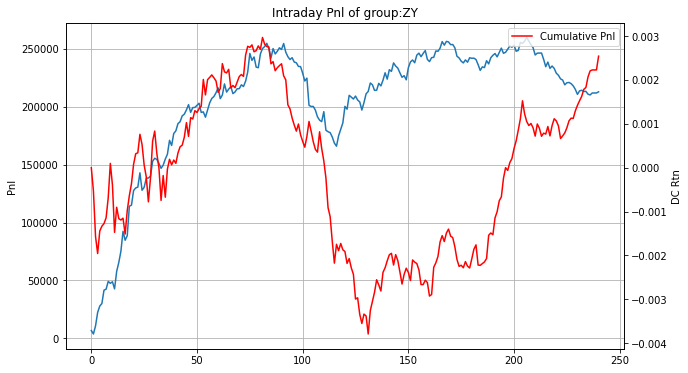

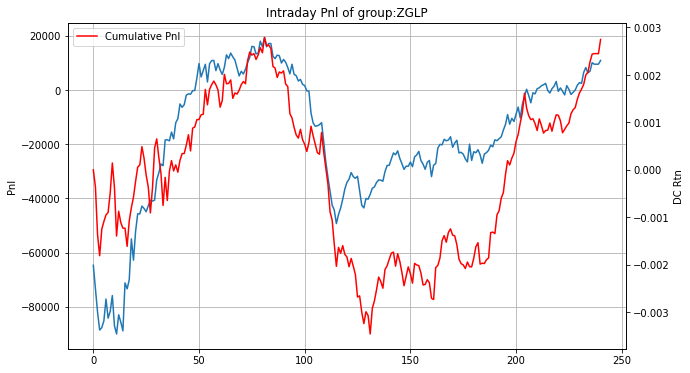

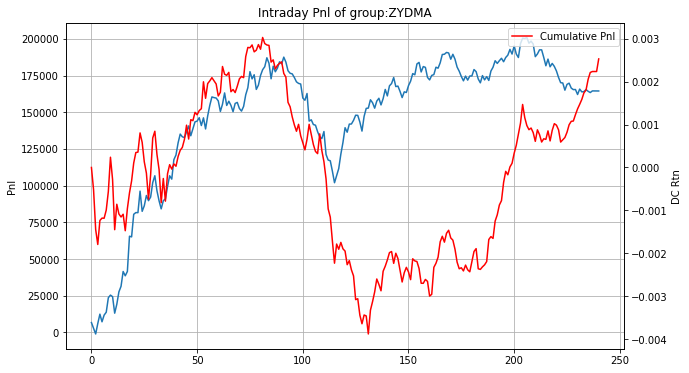

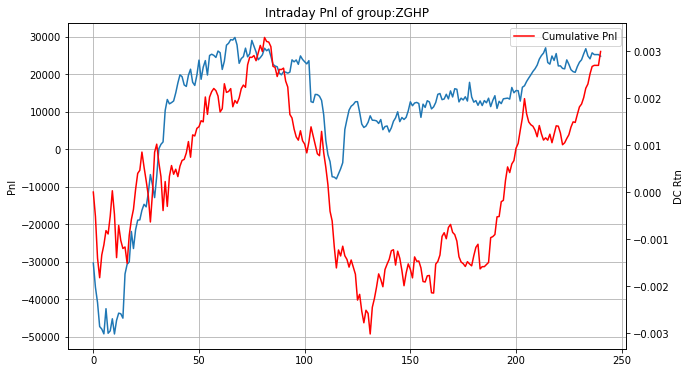

In [83]:
# 绘图
date = '20230411'
portfolio_info = get_portfolio_info(date)
for group in list(set(portfolio_info["Group"])):
    accounts = list(portfolio_info[portfolio_info["Group"] == group]["Account"])
    account_str = "','".join(accounts)
    query = """
    SELECT *
    FROM hp.IntradayPnl
    WHERE Date = '{date}' and Account in ('{account_str}')
    """.format(date=date,account_str=account_str)
    df = client.query_dataframe(query)
    fig = plt.figure(figsize=(10,6))
    plt.grid()
    plt.title("Intraday Pnl of group:{}".format(group))
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    ax.plot(df.groupby("IntradayTime").sum()["CumPnl"])
    ax2.plot(df.groupby("IntradayTime").mean()["Rtn"],color='red')
    ax.set_ylabel("Pnl")
    ax2.set_ylabel("DC Rtn")
    plt.legend(["Cumulative Pnl","Pool Return"])
    plt.show()

## 预测分析 - 全票 vs 底仓

Error on 192.168.47.110:9000 ping: Unexpected EOF while reading bytes
Connection was closed, reconnecting.
Error on socket shutdown: [Errno 107] Transport endpoint is not connected


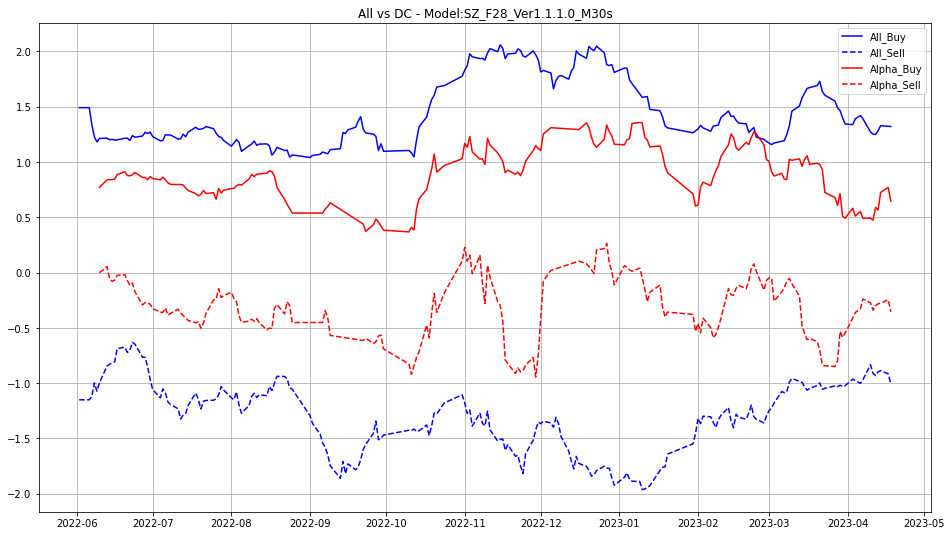

In [85]:
def compare_pool(model,pool="DC",quantile=1,offset_type="History"):
    df_all = get_exp_by_model(pool="All",quantile=quantile,offset_type=offset_type)
    df_alpha = get_exp_by_model(pool=pool,quantile=quantile,offset_type=offset_type)
    df_all = df_all[df_all["Model"] == model]
    df_alpha = df_alpha[df_alpha["Model"] == model]
    plt.figure(figsize=(16,9))
    plt.title("All vs {} - Model:{}".format(pool,model))
    plt.plot(pd.to_datetime(df_all["Date"]),df_all["ExpBuy"].rolling(10,min_periods=2).mean(),color="blue")
    plt.plot(pd.to_datetime(df_all["Date"]),df_all["ExpSell"].rolling(10,min_periods=2).mean(),color="blue",linestyle="--")
    plt.plot(pd.to_datetime(df_alpha["Date"]),df_alpha["ExpBuy"].rolling(10,min_periods=2).mean(),color="red")
    plt.plot(pd.to_datetime(df_alpha["Date"]),df_alpha["ExpSell"].rolling(10,min_periods=2).mean(),color="red",linestyle="--")
    plt.legend([
        "All_Buy",
        "All_Sell",
        "Alpha_Buy",
        "Alpha_Sell",
    ])
    plt.grid()
    plt.show()
compare_pool("SZ_F28_Ver1.1.1.0_M30s")

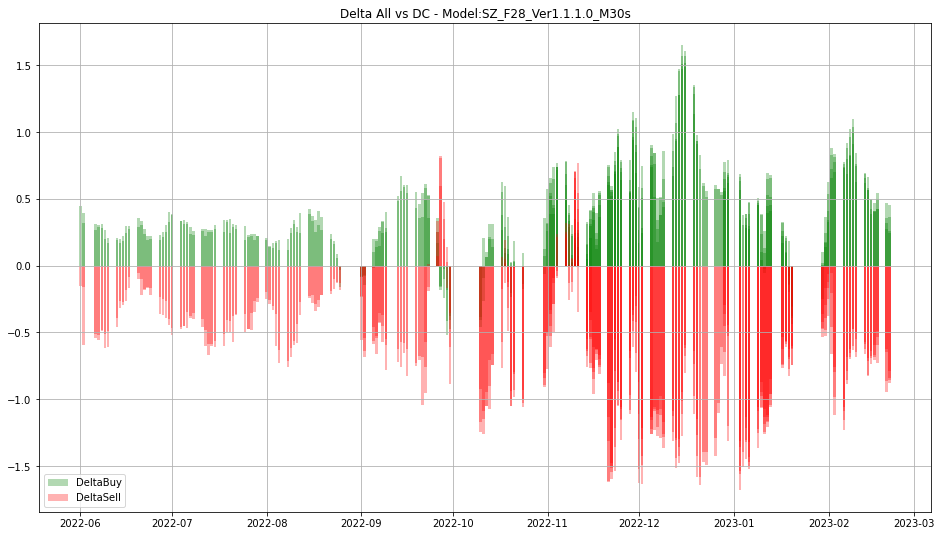

In [87]:
# def compare_pool(model,pool="DC",quantile=1,offset_type="History"):
quantile = 1
offset_type = 'History'
model = 'SZ_F28_Ver1.1.1.0_M30s'
pool = 'DC'
df_all = get_exp_by_model(pool="All",quantile=quantile,offset_type=offset_type)
df_alpha = get_exp_by_model(pool=pool,quantile=quantile,offset_type=offset_type)
df_alpha_idx = df_alpha["Date"].isin(df_all.Date)
df_all_idx = df_all["Date"].isin(df_all.Date)

df_all = df_all[df_all_idx]
df_alpha = df_alpha[df_alpha_idx]
plt.figure(figsize=(16,9))
plt.title("Delta All vs {} - Model:{}".format(pool,model))
plt.bar(df_all.Date,df_all["ExpBuy"].rolling(10,min_periods=2).mean() - df_alpha["ExpBuy"].rolling(10,min_periods=2).mean(),color="green",alpha=0.3)
plt.bar(df_all.Date,df_all["ExpSell"].rolling(10,min_periods=2).mean() - df_alpha["ExpSell"].rolling(10,min_periods=2).mean(),color="red",alpha=0.3)
plt.legend([
    "DeltaBuy",
    "DeltaSell",
])
plt.grid()
plt.show()
# compare_pool("SZ_F28_Ver1.1.1.0_M30s")

# 预测分析 - 成交 vs 挂单

Error on 192.168.47.110:9000 ping: Unexpected EOF while reading bytes
Connection was closed, reconnecting.
Error on socket shutdown: [Errno 107] Transport endpoint is not connected


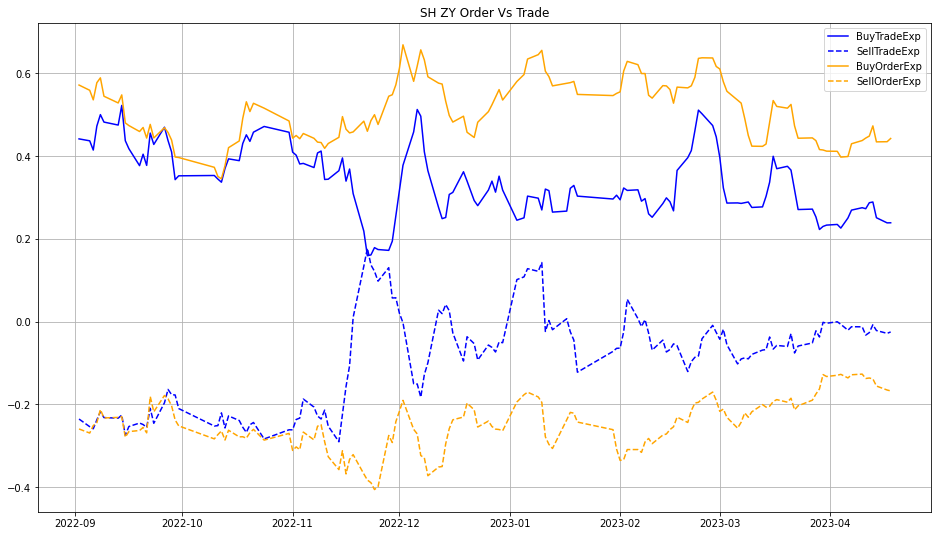

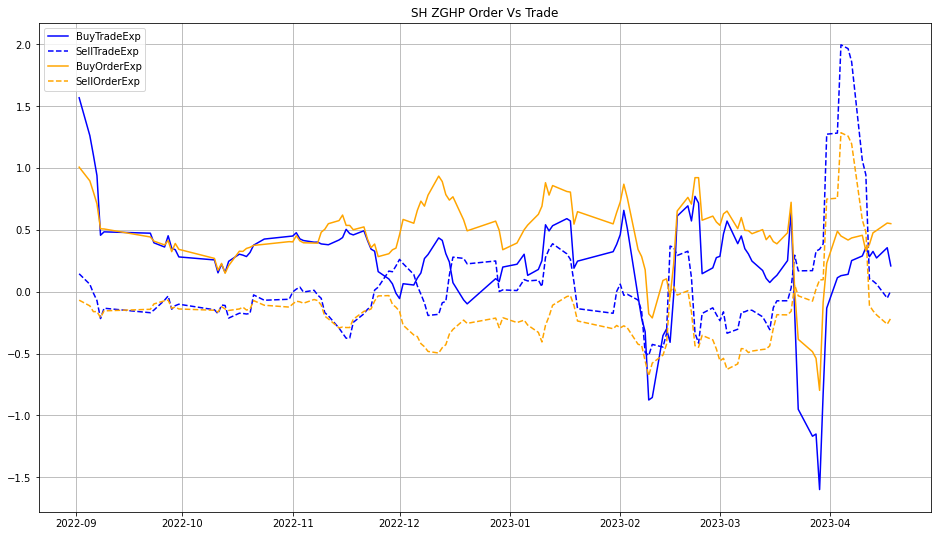

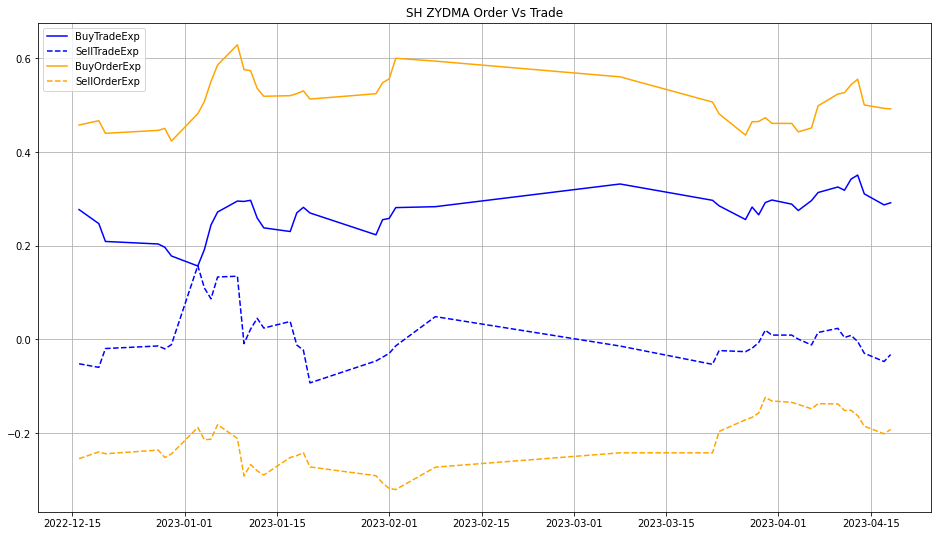

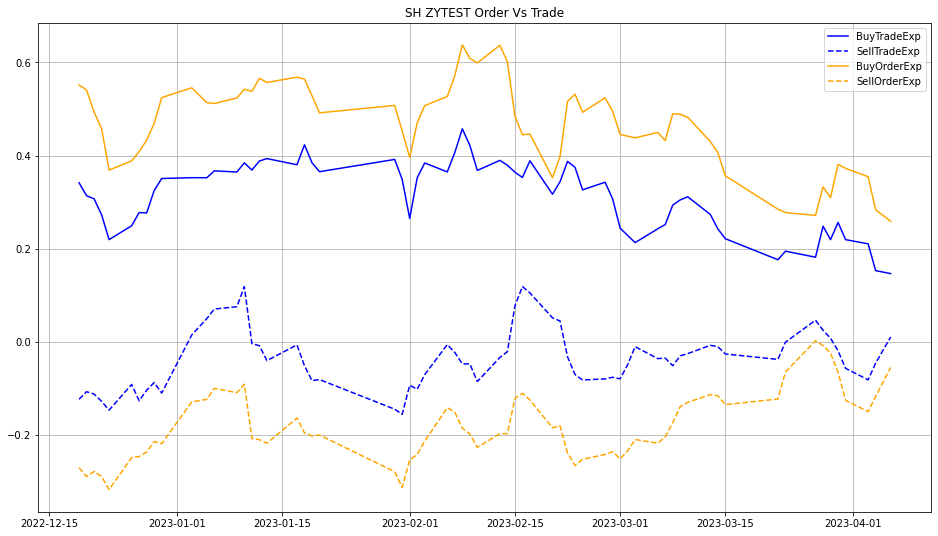

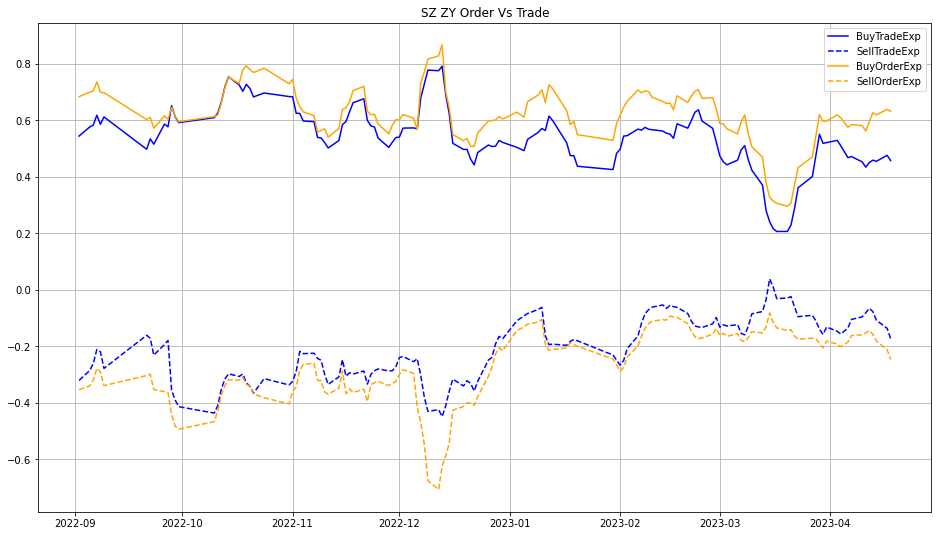

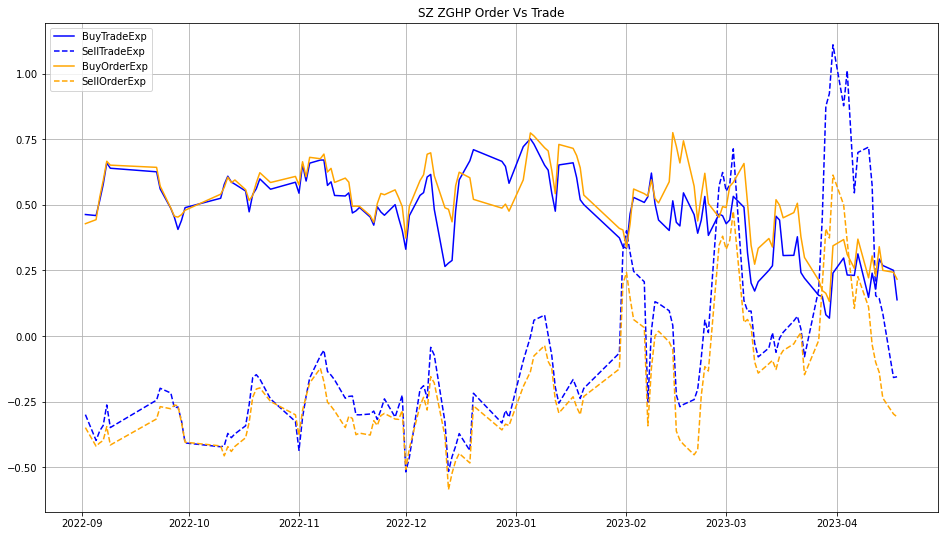

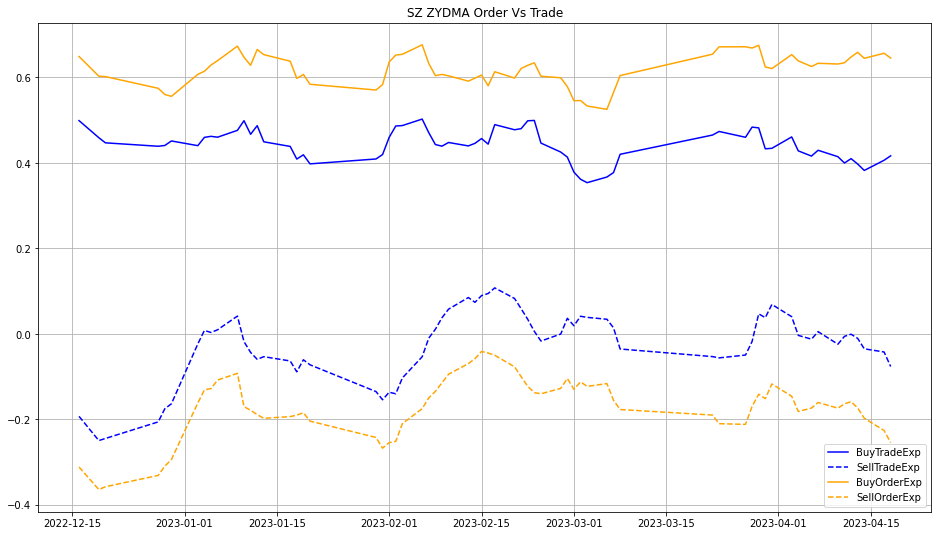

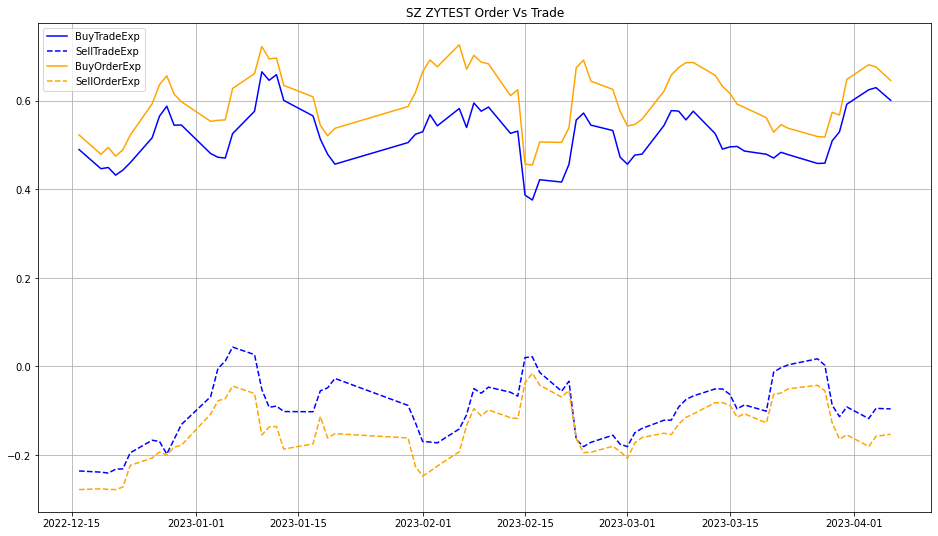

In [88]:
# 画图
def get_exp_by_group(market,group,date='20200101'):
    query_code = """
    SELECT *
    FROM hp.TradeExpByGroup
    WHERE Group = '{group}' and Market = '{market}' and Date >= '{date}'
    """.format(group=group,market=market,date=date)
    df = client.query_dataframe(query_code)
    return df

market_list = ["SH","SZ"]
group_list = ["ZY",'ZGHP','ZYDMA','ZYTEST']
for market in market_list:
    for group in group_list:
        df_test = get_exp_by_group(market,group,date='20220901')
        plt.figure(figsize=(16,9))
        plt.title("{} {} Order Vs Trade".format(market,group))
        legend_list = [
            "BuyTradeExp","SellTradeExp","BuyOrderExp","SellOrderExp"
        ]
        plt.plot(pd.to_datetime(df_test["Date"]),df_test["BuyTradeExp"].rolling(5,min_periods=2).mean(),color="blue")
        plt.plot(pd.to_datetime(df_test["Date"]),df_test["SellTradeExp"].rolling(5,min_periods=2).mean(),color="blue",linestyle="--")
        plt.plot(pd.to_datetime(df_test["Date"]),df_test["BuyOrderExp"].rolling(5,min_periods=2).mean(),color="orange")
        plt.plot(pd.to_datetime(df_test["Date"]),df_test["SellOrderExp"].rolling(5,min_periods=2).mean(),color="orange",linestyle="--")
        plt.legend(legend_list)
        plt.grid()
        plt.show()

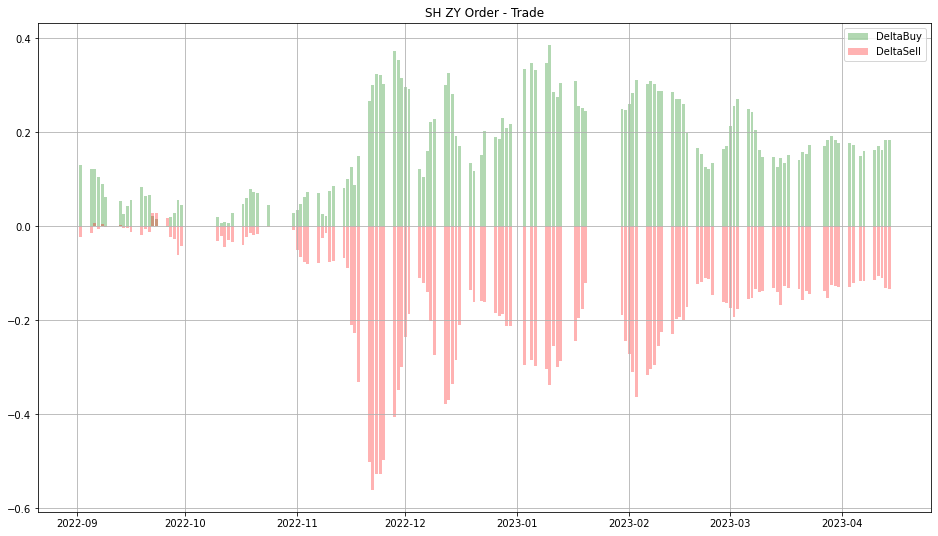

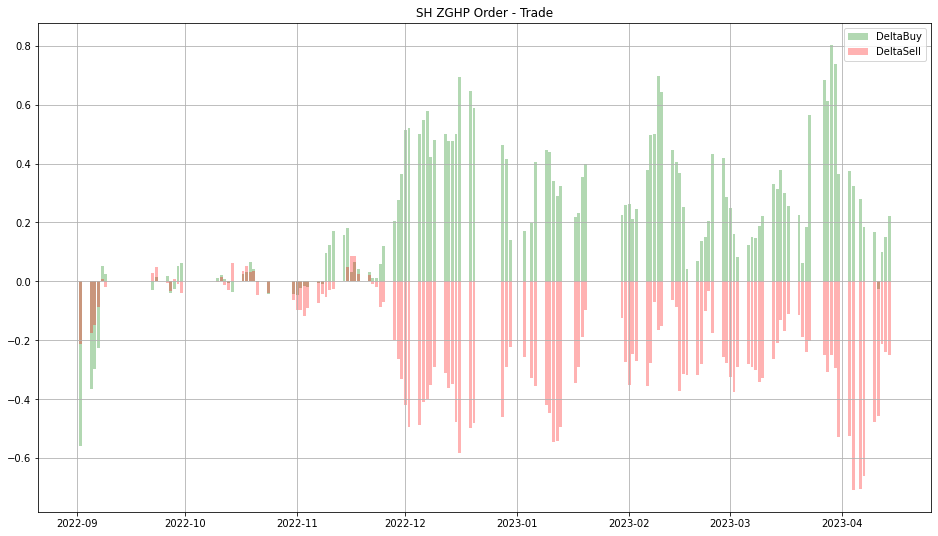

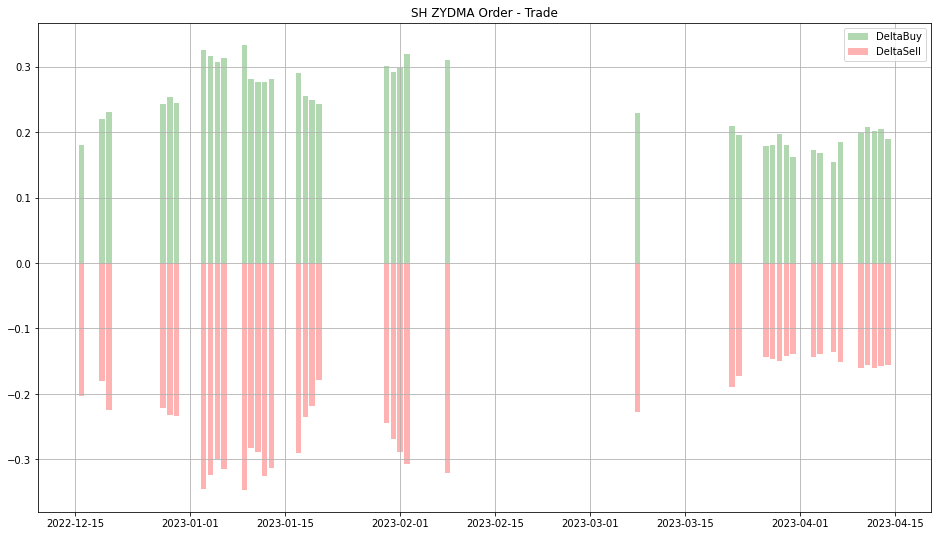

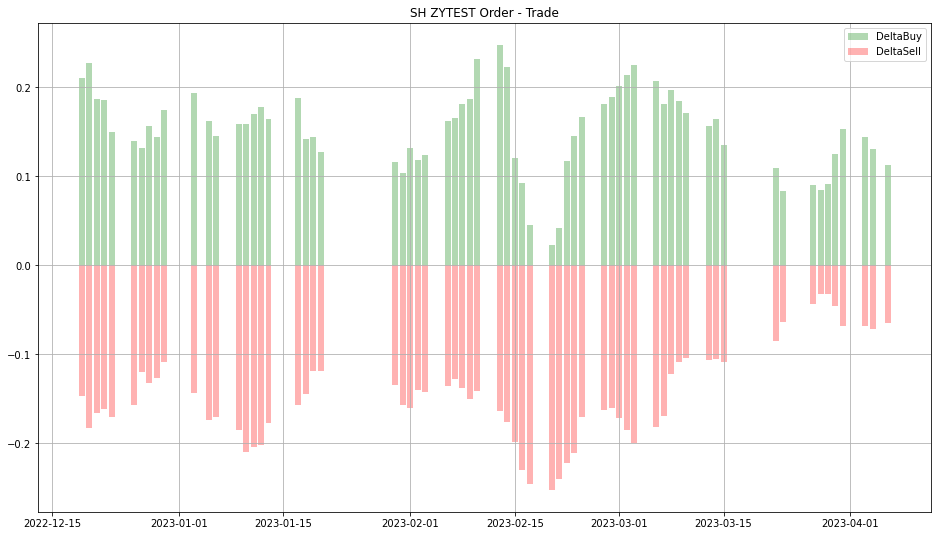

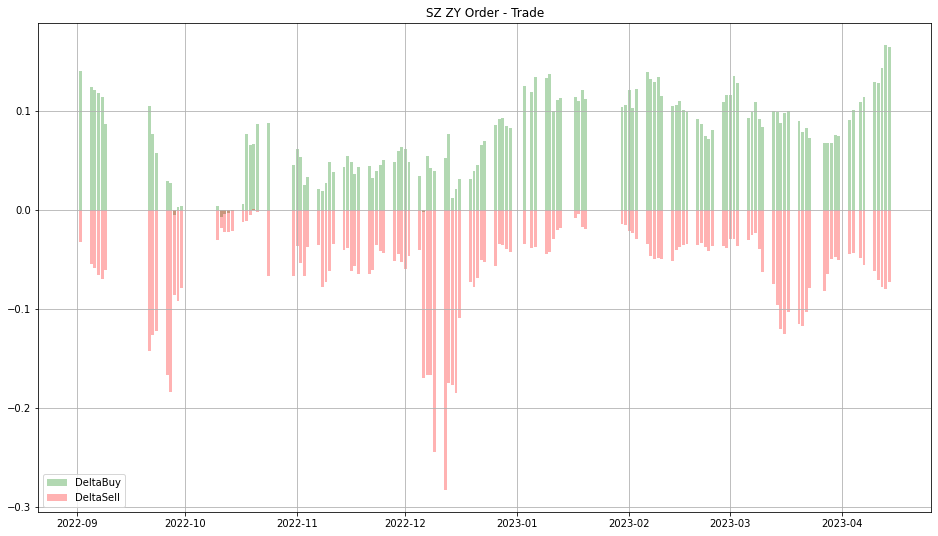

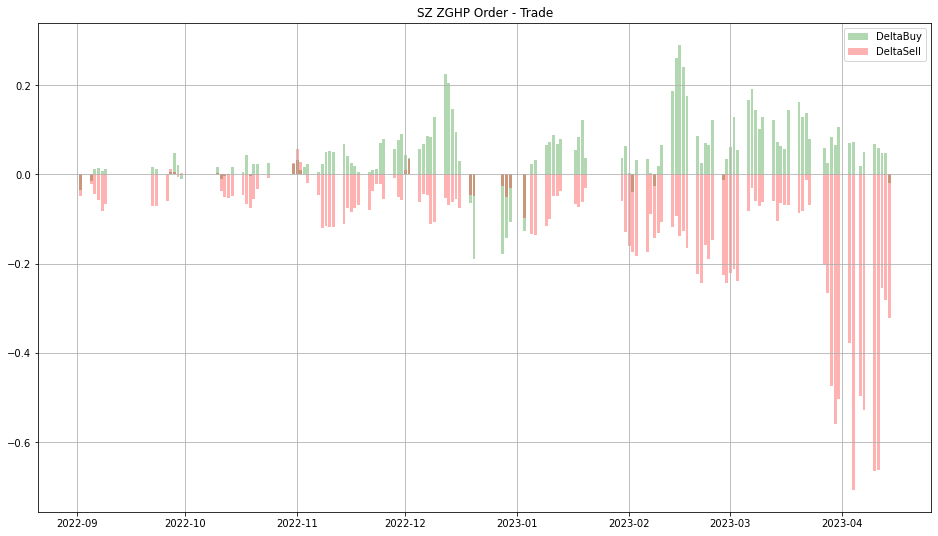

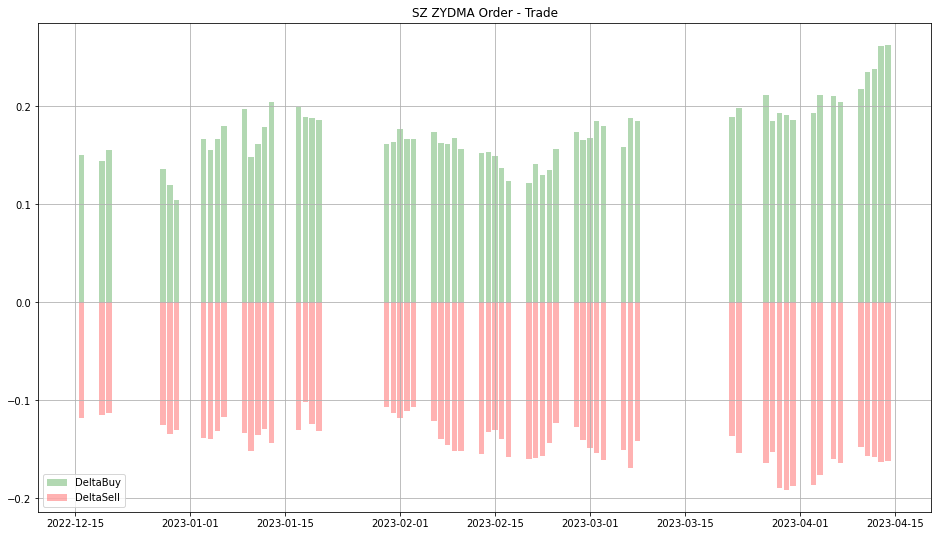

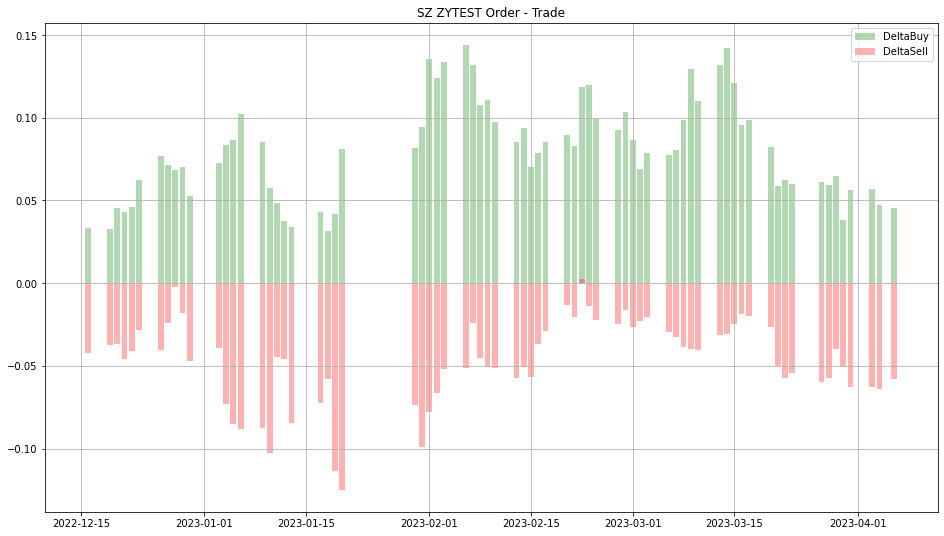

In [69]:
market_list = ["SH","SZ"]
group_list = ["ZY",'ZGHP','ZYDMA','ZYTEST']
for market in market_list:
    for group in group_list:
        df_test = get_exp_by_group(market,group,date='20220901')
        plt.figure(figsize=(16,9))
        plt.title("{} {} Order - Trade".format(market,group))
        legend_list = [
            "DeltaBuy","DeltaSell"
        ]
        plt.bar(pd.to_datetime(df_test["Date"]),df_test["BuyOrderExp"].rolling(5,min_periods=2).mean()
                 - df_test["BuyTradeExp"].rolling(5,min_periods=2).mean(),color="green",alpha=0.3)
        plt.bar(pd.to_datetime(df_test["Date"]),df_test["SellOrderExp"].rolling(5,min_periods=2).mean()
                 - df_test["SellTradeExp"].rolling(5,min_periods=2).mean(),color="red",alpha=0.3)
        plt.legend(legend_list)
        plt.grid()
        plt.show()